# Case Study

## Background

Heart disease is the leading cause of death globally. __Heart failure__ is the primary cause of heart diseases, and that refers to a physiological state in which the heart is unable to pump sufficiently to maintain blood flow to meet the body's need. It usually occurs because the heart has become too weak or stiff. 

HF is routinely diagnosed by:
* __Electrocardiogram (ECG)__, which measure heart's rhythm and electrical activity. From the ECG the QRS duration can be computed. An increased QRS duration, indicate dyssynchronous contraction and relaxation of the left and right ventricles and it is a marker of detection of HF subjects.
* __MRI__ or __US imaging__ which provides structural and functional information of the heart. Evaluation of the structure and the function of the ventricles can provide useful information for diagnosis and characterization of disease. 
 	 	
Based on the result of these tests, doctors use NYHA class to classify patients' heart failure according to the severity of their symptoms:

__Class I__: no limitation is experienced in any activities; there are no symptoms from ordinary activities.

__Class II__: slight, mild limitation of activity; the patient is comfortable at rest or with mild exertion.

__Class III__: marked limitation of any activity; the patient is comfortable only at rest.

__Class IV__: any physical activity brings on discomfort and symptoms occur at rest.

### Current diagnostic technique

Currently, the parameters used in clinics to identify cardiac patients are:
* __LVEDV__ which is the maximum amount of blood that heart can pump
* __LVESV__ which is the minium amount of blood that heart can pump
* __LVSV__ which is the amount of blood pumped by the left ventricle of the heart in one contraction. 
* __Ejection fraction (LVEF)__, which computes the amount of blood of the left ventricle (LV) pumps out with each contraction. A normal heart’s ejection fraction may be between 50 and 70 percent.

## Objective

The objective of this workshop is twofold:

1. Improve the quality of a pre-trained segmentation neural network to segment the left ventricle (LV) of the heart
2. Train a simple deep neural network (DNN) to classify between healthy and heart failure subjects using clinical metrics, i.e. LVEDV, LVESV, LVSV and LVEF


# 1. Image segmentaion


In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. Below is the code for setting up a segmentation network and training it. The network isn't very good, so the exercise is to improve the quality of the segmentation by improving the network. 

The data being used here is derived from the Sunnybrook Dataset (https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac images, filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

PyTorch documentation can be found here: https://pytorch.org/docs/stable/index.html


## Imports

In [2]:
%matplotlib inline

import os
import numpy as np
import pylab as plt
import torch
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit


## Download dataset


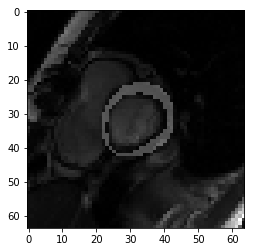

In [4]:
![ -f scd_lvsegs.npz ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz

data=np.load('scd_lvsegs.npz') # load all the data from the archive

images=data['images'] # images in BHW array order
segs=data['segs'] # segmentations in BHW array order
caseIndices=data['caseIndices'] # the indices in `images` for each case

images=images.astype(np.float32)/images.max() # normalize images

plt.imshow(images[13]+segs[13]*0.25,cmap='gray') # show image 13 with segmentation

## Split data into training and test

For this exercise, we will divide the data between train and test data, choosing to retain the last 6 cases as our test set. Typically you would want to have a training dataset, a validation dataset checked periodically during training to ensure the network continues to produce good results for data is isn't trained on, and a test dataset used to validate the training after the fact. 

In [5]:
testIndex=caseIndices[-6,0] # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs=images[:testIndex],segs[:testIndex]
testImages,testSegs=images[testIndex:],segs[testIndex:]

## Define segmentation network

As loss function, for this exercise we will use the binary Dice loss, which measure the overlap between the ground truth segmentation and the predicted segmentation

As neural network, we used a simple auto-encoder, which which has a down-sampling path with three layers using strided convolutions to reduce dimensions. After the bottom layer the decoding path upsamples using strided transpose convolutions. Dropout is added in places to reduce over-fitting.

However, the current network architecture is doing poorly. Modify the current network to improve the segmentation accuracy. Some of the possible solutions are:
- Change kernel size
- Add layers
- Change dropout value
- Change activation function
- Think of another strategy for batch normalisation
- Add data augmentation

In [6]:
# Dice loss 
class DiceLoss(nn.modules.loss._Loss):
    '''This defines the binary dice loss function used to assess segmentation overlap.'''
    def forward(self, source, target, smooth=1e-5):
        batchsize = target.size(0)
        source=source.sigmoid() # apply sigmoid to the source logits to impose it onto the [0,1] interval
        
        # flatten target and source arrays to 2D BV arrays
        tsum=target.view(batchsize, -1) 
        psum=source.view(batchsize, -1)
        
        intersection=psum*tsum
        sums=psum+tsum 

        # compute the score, the `smooth` value is used to smooth results and prevent divide-by-zero
        score = 2.0 * (intersection.sum(1) + smooth) / (sums.sum(1) + smooth)
        
        # `score` is 1 for perfectly identical source and target, 0 for entirely disjoint
        return 1 - score.sum() / batchsize

# Segmentation network
class SegNet(nn.Module):
    '''
    My solution is a simple autoencoder which has a downsampling path with three layers using strided convolutions
    to reduce dimensions. After the bottom layer the decoding path upsamples using strided transpose convolutions. 
    Dropout is added in places to reduce overfitting.
    '''
    def __init__(self):
        super().__init__()
        
        self.model=nn.Sequential(
            # layer 1
            nn.Conv2d(1,4,3,2,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            # layer 2
            nn.Conv2d(4,8,3,2,1),
            nn.InstanceNorm2d(8),
            nn.PReLU(),
            nn.Dropout2d(),
            # layer 3
            nn.Conv2d(8,16,3,2,1),
            nn.InstanceNorm2d(16),
            nn.PReLU(),
            # bottom layer
            nn.Conv2d(16,16,3,1,1),
            nn.Dropout2d(),
            # layer 5
            nn.ConvTranspose2d(16,8,3,2,1,1),
            nn.InstanceNorm2d(8),
            nn.PReLU(),
            # layer 6
            nn.ConvTranspose2d(8,4,3,2,1,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            nn.Dropout2d(),
            # layer 7
            nn.ConvTranspose2d(4,2,3,2,1,1),
            nn.InstanceNorm2d(2),
            nn.PReLU(),
            # layer 8: output
            nn.Conv2d(2,1,3,1,1),
        )
        
    def forward(self,x):
        return self.model(x)

# Alternative Solution - Unet
class UnetBlock(nn.Module):
    '''
    This unet implementation is defined with blocks containing the down and up path for each level of the network.
    Recall that unet looks something like this where [] is a block of layers (convolutions, activation, etc.):
    
    ->[]-------------->+[]->   This class implements one   -->[encode]--------->+->[decode]-->
       |               |       level of this structure            |             ^
       \->[]----->+[]->/       where a subblock is the            |             |
           |      |            bottom or another layer:           \->[subblock]-/
           \->[]->/
    '''
    def __init__(self,inChannels,outChannels,subblock):
        super().__init__()
        self.encode=nn.Conv2d(inChannels,outChannels,3,2,1)
        self.eIN=nn.InstanceNorm2d(outChannels)
        self.eDrop=nn.Dropout2d(0.15)
        self.eAct=nn.PReLU()
        
        self.decode=nn.ConvTranspose2d(outChannels*2,inChannels,3,2,1,1)
        self.dIN=nn.InstanceNorm2d(inChannels)
        self.dDrop=nn.Dropout2d(0.15)
        self.dAct=nn.PReLU()
        
        # sublock is either another instance of UnetBlock or a Sequential instance
        self.subblock=subblock
        
    def forward(self,x):
        #encode stage
        enc=self.encode(x)
        enc=self.eIN(enc)
        enc=self.eDrop(enc)
        enc=self.eAct(enc)
        
        # pass through subblock and concat
        sub=self.subblock(enc)
        sub=torch.cat([enc,sub],1)
        
        #decode stage
        dec=self.decode(sub)
        dec=self.dIN(dec)
        dec=self.dDrop(dec)
        dec=self.dAct(dec)
        
        return dec
    

class UNet(nn.Module):
    '''The network is built from the bottom up using the blocks to define each layer added onto the previous.'''
    def __init__(self):
        super().__init__()
        # bottom subblock
        net=nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.InstanceNorm2d(64),
            nn.PReLU(),
        )

        # build the unet structure from the bottom up
        net=UnetBlock(32,64,net)
        net=UnetBlock(16,32,net)
        net=UnetBlock(8,16,net)
        net=UnetBlock(4,8,net)

        # final top-level structure omits dropout and applies sigmoid to the output
        self.model=nn.Sequential(
            nn.Conv2d(1,4,3,1,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            net,
            nn.Conv2d(4,1,3,1,1),
        )
        
    def forward(self,x):
        return self.model(x)

## Train network

Once we have defined the network, we need to train it. An strategy is to load the whole dataset into memory at once, but typically this isn't possible due to memory restrictions. A different strategy is to create batches for each train step, which means that in each iteration only few image (batch) would be used for training. This strategy is handled by the data loader.

It is also possible to apply some transformations to the data before being forward passed through the network, this is generally called data augmentation.

250 0.5919378995895386
500 0.5112576484680176
750 0.4769061207771301
1000 0.4587157964706421
1250 0.44043707847595215
1500 0.44220244884490967
1750 0.4241245985031128
2000 0.43153882026672363
2250 0.4275054931640625
2500 0.4176589846611023
2750 0.4256197214126587
3000 0.41538721323013306
3250 0.41782480478286743
3500 0.4375830292701721
3750 0.4178273677825928
4000 0.4173312187194824
4250 0.4033104181289673
4500 0.42053455114364624
4750 0.4002167582511902
5000 0.41328150033950806
CPU times: user 5min 49s, sys: 1min 53s, total: 7min 42s
Wall time: 7min 42s


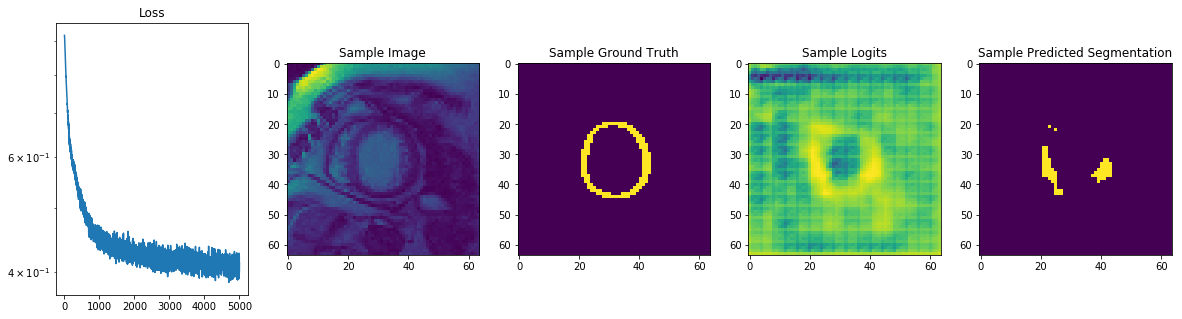

In [7]:
%%time
# store the training data as tensors
trainTensor=torch.from_numpy(trainImages[:,None])
segTensor=torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net=SegNet()
# net=UNet()

# choose a device and move the net and tensors to its memory
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net=net.to(device)
trainTensor=trainTensor.to(device)
segTensor=segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps=5000 # changed from 100
losses=[]

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    pred=net(trainTensor)
    lossval=loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20)==0:
        print(t,lossval.item())    
    

# sample an image from the training data and look at the segmentation the network predicted for it
sample=10
predSample=pred[sample,0].cpu().data.numpy()
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(losses)
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[10])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[10])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)

## Test
Once the network is been train, we can now apply the test data to the network. These images were never seen by the network so how well the task is performed is an indicator of how generalized and robust the network is:

Test loss: 0.3337540626525879


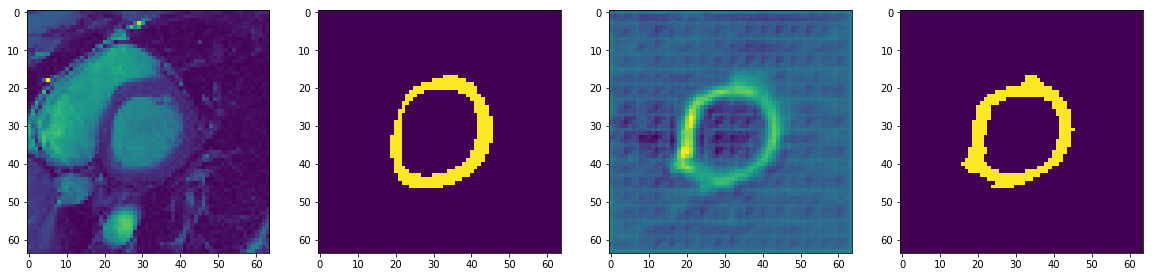

In [9]:
testTensor=torch.from_numpy(testImages[:,None]).to(device)
testSegTensor=torch.from_numpy(testSegs[:,None]).to(device).float()

net.to(device)
net.eval()
pred=net(testTensor)
testloss=loss(pred,testSegTensor).item() # calculate test loss

pred=pred.to('cpu').data.numpy()

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(testImages[10])
ax[1].imshow(testSegs[10])
ax[2].imshow(pred[10,0])
ax[3].imshow(seg[10,0])

print('Test loss:',testloss)

# 2. Classification using clinical metrics 

In this part of the workshop, we aim to use the segmentations produced from the previous segmentation network to compute the following clinical metrics LVEDV, LVESV, LVSV and LVEF to classify the between healthy and heart failure subjects.

## DNN network

For classification, we will use a deep neural network classifier (DNN) with two layers with sizes 20 and 10. To evaluate the performances of the classifier we will compute accuracy, precision and recall.

In [18]:
def compute_metrics(y_true, yPred, target_names):
    """ Compute metrics
    Parameters
    ----------
    yPred: labels predicted using DNN
    y_true: ground truth labels
    target_names:  names matching the labels
    """

    BACC = balanced_accuracy_score(y_true, yPred)
    PRE = precision_score(y_true, yPred, average=None)
    REC = recall_score(y_true, yPred, average=None)
    print('Balanced accuracy  {0:.2f}'.format(BACC))

    headers = ["precision", "recall"]

    rows = zip(target_names, PRE, REC)

    digits = 2
    longest_last_line_heading = 'weighted avg'
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = u'{:>{width}s} ' + u' {:>9}' * len(headers)
    report = head_fmt.format(u'', *headers, width=width)
    report += u'\n\n'
    row_fmt = u'{:>{width}s} ' + u' {:>9.{digits}f}' + u' {:>9}\n'
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    report += u'\n'

    print(report)

    return BACC * 100, PRE * 100, REC * 100
    
# Create a DNN network for classification with two layers with sizes 20 and 10. 
class DNN(torch.nn.Module):
    '''Plain dense neural network of linear layers using dropout and ReLU activation.'''

    def __init__(self, numClasses):
        super().__init__()
        self.hiddens = torch.nn.Sequential(
            torch.nn.Linear(4, 20),
            torch.nn.Dropout(0.05),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.Dropout(0.05),
            torch.nn.ReLU(),
            torch.nn.Linear(10, numClasses),
        )

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        x = self.hiddens(x)
        return F.softmax(x, 1)

## Download the data
To ensure that everyone work with the same data, download the following file that contains the images segmented with the previous network optimised.

In [11]:
![ -f data.npz ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/data.npz
data_file_name = 'data.npz'

## Compute clinical metricas and save them in a matrix called metrics
- LVEDV (maximum volume of the cardiac cycle)
- LVESV (minimum volume of the cardiac cycle)
- LVSV = LVEDV - LVESV 
- LVEF = LVSV/LVEDV*100 

Then:
- Generate a matrix ```metrics``` that concatenate LVEDV, LVESV, LVSV and LVEF

In [35]:
# Load data
data = np.load(data_file_name)

# Save fields inside data
images = data['images']  # (805, 128, 128)
segs = data['segs']  # (805, 128, 128)
caseNames = data['caseNames']  # 45
caseIndices = data['caseIndices']  # 45
caseTypeNames = ['Normal', 'Heart Failure']
caseTypes = data['caseTypes']  # 45
caseTypes[caseTypes == 2] = 0
caseVoxelSize = data['caseVoxelSize']
isEDImg = data['isEDImg']  # 805
segTypes = data['segTypes']  # ['Background', 'LV Pool']


# Compute LVEDV, LVESV, LVSV and LVEF
metrics = np.zeros((len(caseNames), 4))
for ii, ind in enumerate(caseIndices):
    indED_pat = isEDImg[ind[0]:ind[1]]
    img_pat = images[ind[0]:ind[1], :, :]
    seg_pat = segs[ind[0]:ind[1], :, :]
    img_ED = img_pat[indED_pat, :, :]
    img_ES = img_pat[~indED_pat, :, :]
    seg_ED = seg_pat[indED_pat, :, :]
    seg_ES = seg_pat[~indED_pat, :, :]
    dx, dy, dz = caseVoxelSize[ii]
    volume_per_voxel = dx * dy * dz * 1e-3
    density = 1.05

    metrics[ii, 0] = np.sum(np.sum(seg_ED == 1, axis=1)) * volume_per_voxel
    metrics[ii, 1] = np.sum(np.sum(seg_ES == 1, axis=1)) * volume_per_voxel
    metrics[ii, 2] = metrics[ii, 0] - metrics[ii, 1]
    metrics[ii, 3] = metrics[ii, 2] / metrics[ii, 0] * 100


## Visualize the data

Plot LVEDV, LVESV, LVSV and LVEF per groups, i.e. LVEDV and LVESV, LVSV and LVEF

Text(0, 0.5, 'LVEF')

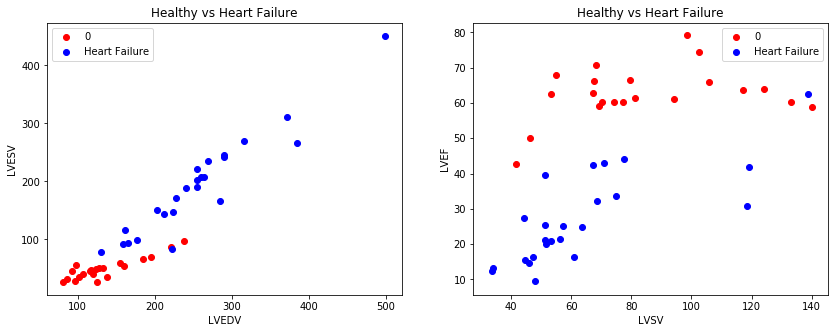

In [31]:
def PlotTwoClassData(X, y, title, _caseTypeNames):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', label=_caseTypeNames[0])
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', label=_caseTypeNames[1])
    plt.legend()
    plt.title(title)
    

plt.figure(figsize = [14,5])
plt.subplot(121)
PlotTwoClassData(metrics[:,0:2], caseTypes, 'Healthy vs Heart Failure', caseTypeNames)
plt.xlabel('LVEDV')
plt.ylabel('LVESV')
plt.subplot(122)
PlotTwoClassData(metrics[:,2:], caseTypes, 'Healthy vs Heart Failure', caseTypeNames)
plt.xlabel('LVSV')
plt.ylabel('LVEF')


## Split data into training and test

Data is unbalanced (there is no the same number of patients per group). We need to ensure that in the split training/test there is balanced number of classed. To this end use StratifiedShuffleSplit from scikit-learn that will automatically ensure that.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [32]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes):
    X_train, X_test = metrics[train_index, :], metrics[test_index, :]
    y_train, y_test = caseTypes[train_index], caseTypes[test_index]

## Train a DNN network to perform classification


1000 0.3629697561264038
2000 0.3163280189037323
3000 0.3329834043979645
4000 0.3322892487049103
5000 0.3134070634841919
6000 0.3150540888309479
7000 0.31327345967292786
8000 0.31342655420303345
9000 0.313744455575943
10000 0.3132743537425995


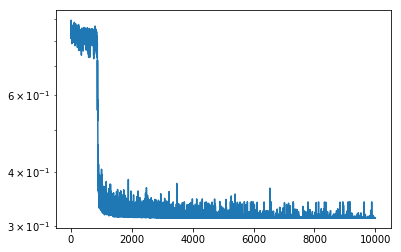

In [33]:
nb_iters = 10000
output_size = len(np.unique(caseTypes))
net = DNN(output_size)

xt = torch.from_numpy(X_train).type(torch.FloatTensor)
yt = torch.from_numpy(y_train).type(torch.LongTensor)

loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
opt = torch.optim.Adam(net.parameters(), lr=0.0001)

losses = []

for i in range(1, nb_iters + 1):
    out = net(xt)  # input x and predict based on x
    loss = loss_func(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    opt.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    opt.step()  # apply gradients

    losses.append(loss.item())

    if i % (nb_iters // 10) == 0:
        print(i, losses[-1])

plt.figure()
plt.semilogy(losses)
plt.show()


# Deploy network and compute metrics

First deploy the trained netowrk and then compute the following metrics: balanced accuracy, precision, recall


In [36]:
with torch.no_grad():
    net.eval()
    out = torch.from_numpy(X_test).float()
    out = net(out).data.numpy()
    y_pred = np.argmax(out, axis=1)

    # Compute metrics
    compute_metrics(y_test, y_pred, caseTypeNames)

Balanced accuracy  0.90
               precision    recall

       Normal       0.80       1.0
Heart Failure       1.00       0.8


